<a href="https://colab.research.google.com/github/zolzayakh/Dive-into-coding/blob/main/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Neural network in scratch**

In [1]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8

#flattened
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
uint8


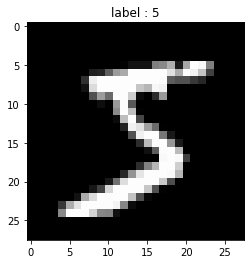

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [3]:
import numpy as np
#Preprocessing 
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1.0
0.0


In [4]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


**[Problem 1] Creating a code that determines the initial value of the weight**

In [6]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self,batch_size = 20,n_features = 784,n_nodes1 = 400,n_nodes2 = 200,n_output = 10,sigma = 0.02,lr = 0.01,epoch = 10, verbose=True):
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2 
        self.n_output = n_output
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch
        self.loss_train = []
        self.loss_val = []
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B1 = self.sigma * np.random.randn(1, self.n_nodes1)
        self.B2 = self.sigma * np.random.randn(1, self.n_nodes2)
        self.B3 = self.sigma * np.random.randn(1, self.n_output)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """

        for _ in range(self.epoch):
          get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
          for mini_X_train, mini_y_train in get_mini_batch:
            self.forward(mini_X_train)
            self.backward(mini_X_train, mini_y_train)
          self.forward(X)
          self.loss_train.append(self.cross_entropy_error(y, self.Z3))
          if X_val is not None:
            self.forward(X_val)
            self.loss_val.append(self.cross_entropy_error(y_val, self.Z3))
        if self.verbose:
          if X_val is None:
            print(self.loss_train)
          else:
            print(self.loss_train,self.loss_val)

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        self.forward(X)
        return np.argmax(self.Z3, axis=1)

    def forward(self, X):
      self.A1 = X @ self.W1 + self.B1
      self.Z1 = self.tanh(self.A1)
      self.A2 = self.Z1 @ self.W2 + self.B2
      self.Z2 = self.tanh(self.A2)
      self.A3 = self.Z2 @ self.W3 + self.B3
      self.Z3 = self.softmax(self.A3)
    
    def backward(self, X, y):
      dA3 = (self.Z3 - y)/self.batch_size
      dW3 = self.Z2.T @ dA3
      dB3 = np.sum(dA3, axis=0)
      dZ2 = dA3 @ self.W3.T
      dA2 = dZ2 * (1 - self.tanh(self.A2)**2)
      dW2 = self.Z1.T @ dA2
      dB2 = np.sum(dA2, axis=0)
      dZ1 = dA2 @ self.W2.T
      dA1 = dZ1 * (1 - self.tanh(self.A1)**2)
      dW1 = X.T @ dA1
      dB1 = np.sum(dA1, axis=0)
      self.W3 -= self.lr * dW3
      self.B3 -= self.lr * dB3
      self.W2 -= self.lr * dW2
      self.B2 -= self.lr * dB2
      self.W1 -= self.lr * dW1
      self.B1 -= self.lr * dB1


    def cross_entropy_error(self, y, Z):
      L = - np.sum(y * np.log(Z+1e-7)) / len(y)
      return L

    def relu(self,X):
      result = np.max([np.zeros(X.shape), X], axis=0)   
      return result

    def softmax(self,X):
      result = np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)
      return result

    def sigmoid(self,X):
      result = 1 / (1 + np.exp(-X))   
      return result
    
    def tanh(self,X):
      result = (np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X))
      # or
      #  result = np.tanh(X)
      return result

In [7]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [9]:
nn = ScratchSimpleNeuralNetrowkClassifier(epoch=5)
nn.fit(X_train, y_train, X_val, y_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[0.43577992322199094, 0.3341985209845094, 0.29781046605264727, 0.2745014012089303, 0.2556913873397914] [0.42606052495619134, 0.32611501198489184, 0.29233544006220125, 0.2718295446030428, 0.25566411446156634]


In [10]:
from sklearn.metrics import accuracy_score
pred_train = nn.predict(X_val)
y_val = np.argmax(y_val, axis = 1)
accuracy = accuracy_score(y_val, pred_train)
print ('Accuracy: ' + str(accuracy))

Accuracy: 0.92375


**[Problem 7] Plot of learning curve**

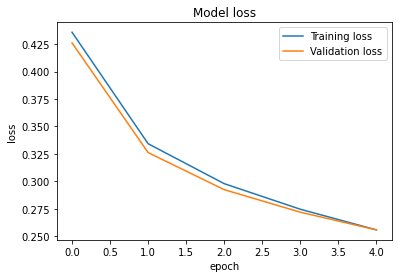

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(nn.epoch), nn.loss_train, label = 'Training loss')
plt.plot(range(nn.epoch), nn.loss_val, label = 'Validation loss')
plt.legend()
plt.xlabel ('epoch')
plt.ylabel ('loss')
plt.title ('Model loss')
plt.show()